In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy import stats
import os
import copy

import os
import re

import seaborn as sns
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates
from scipy.stats import norm


In [2]:


def portfolio_stats_paper_style(returns,
                                periods_per_year=252,
                                rf_annual=0.0,
                                target=0.0,
                                alpha=0.95):

    r = pd.Series(returns).dropna().astype(float).to_numpy()
    if len(r) < 2:
        raise ValueError("need at least 2 observations")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")

    mu = float(np.mean(r))
    sigma2 = float(np.var(r, ddof=0))
    sigma = float(np.sqrt(sigma2))

    mu_ann = mu * periods_per_year
    sigma2_ann = sigma2 * periods_per_year
    sigma_ann = float(np.sqrt(sigma2_ann))

    downside = (r[r < target] - target)
    semivar = 0.0 if downside.size == 0 else float(np.mean(downside**2))
    semidev_ann = float(np.sqrt(semivar * periods_per_year))

    # VaR/CVaR
    q = 1.0 - alpha
    VaR = float(np.quantile(r, q))
    tail = r[r <= VaR]
    CVaR = VaR if tail.size == 0 else float(np.mean(tail))

    # drawdowns
    wealth = np.concatenate([[1.0], np.cumprod(1.0 + r)])
    peak = np.maximum.accumulate(wealth)
    dd = 1.0 - wealth / peak
    pos_dd = dd[dd > 0]
    avg_dd = 0.0 if pos_dd.size == 0 else float(np.mean(pos_dd))

    # excess mean (per-period rf from annual rf)
    rf_per = (1.0 + rf_annual)**(1.0 / periods_per_year) - 1.0
    excess_ann_mean = (mu - rf_per) * periods_per_year

    sharpe = np.nan if sigma_ann == 0 else float(excess_ann_mean / sigma_ann)
    sortino = np.nan if semidev_ann == 0 else float(excess_ann_mean / semidev_ann)

    # tail-adjusted Sharpe (NO annualization of CVaR/mVaR)
    ta_sharpe_cvar = np.nan if CVaR == 0 else float(excess_ann_mean / abs(CVaR))

    # Cornish-Fisher modified VaR
    if sigma == 0:
        skew = 0.0
        exkurt = 0.0
    else:
        xc = r - mu
        m3 = float(np.mean(xc**3))
        m4 = float(np.mean(xc**4))
        skew = m3 / (sigma**3)
        kurt = m4 / (sigma**4)
        exkurt = kurt - 3.0

    z = float(norm.ppf(q))
    z_cf = (z
            + (1/6)  * (z**2 - 1)   * skew
            + (1/24) * (z**3 - 3*z) * exkurt
            - (1/36) * (2*z**3 - 5*z) * (skew**2))

    mVaR = float(mu + sigma * z_cf)
    ta_sharpe_mvar = np.nan if mVaR == 0 else float(excess_ann_mean / abs(mVaR))

    return {
        "Ann. Mean (%)": 100 * mu_ann,
        "Ann. StdDev (%)": 100 * sigma_ann,
        "Ann. SemiDev (%)": 100 * semidev_ann,
        "CVaR 95% (%)": 100 * CVaR,
        "Avg DD (%)": 100 * avg_dd,
        "VaR 95% (%)": 100 * VaR,
        "Sharpe (ann.)": sharpe,
        "Sortino (ann.)": sortino,
        "Tail-Adj Sharpe (CVaR95)": ta_sharpe_cvar,
        "Tail-Adj Sharpe (mVaR95)": ta_sharpe_mvar,
    }


def make_table_for_portfolios(portfolios: dict,
                              periods_per_year=252,
                              rf_annual=0.0,
                              target=0.0,
                              alpha=0.95) -> pd.DataFrame:
    rows = [
        "Ann. Mean (%)",
        "Ann. StdDev (%)",
        "Ann. SemiDev (%)",
        "CVaR 95% (%)",
        "Avg DD (%)",
        "VaR 95% (%)",
        "Sharpe (ann.)",
        "Sortino (ann.)",
        "Tail-Adj Sharpe (CVaR95)",
        "Tail-Adj Sharpe (mVaR95)",
    ]

    out = pd.DataFrame(index=rows)
    for name, r in portfolios.items():
        st = portfolio_stats_paper_style(r, periods_per_year=periods_per_year,
                                         rf_annual=rf_annual, target=target, alpha=alpha)
        out[name] = [st[k] for k in rows]
    return out

def df_to_booktabs_latex(df: pd.DataFrame, caption=None, label=None) -> str:
    latex = df.to_latex(
        escape=True,
        float_format=lambda x: f"{x:.2f}",
        column_format="l" + "r"*df.shape[1],
        bold_rows=False
    )
    # convert to booktabs style
    latex = latex.replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
    if caption or label:
        # wrap in table environment if requested
        body = latex
        lines = ["\\begin{table}[!htbp]", "\\centering"]
        if caption:
            lines.append(f"\\caption{{{caption}}}")
        if label:
            lines.append(f"\\label{{{label}}}")
        lines.append(body.strip())
        lines.append("\\end{table}")
        latex = "\n".join(lines)
    return latex

def build_tau_ensemble_returns_from_chunks(
    dfs_chunked,                 # dict[tau_str][seed][chunk] = DataFrame (can be filtered)
    tau_levels_str=None,         # e.g. ["01","09"]; if None -> sorted(dfs_chunked.keys())
    value_col="absolute_return",
    date_col="date",
    scale=1221.0,                   # e.g. 1221.0 to undo reward scaling
    align="inner",               # "inner":common dates across seeds) 
    drop_duplicate_dates=True,):
    '''
    This function builds an ensemble return series for each tau by first concatenating all chunks per seed 
    into a single time-ordered return series. It then aligns the seed-level return series by date and combines them into a panel.
    Finally, it averages across seeds to produce one aggregated (ensemble) return series per tau
    '''

    if tau_levels_str is None:
        tau_levels_str = sorted(dfs_chunked.keys())

    portfolios_by_tau = {}
    panels_by_tau = {}
    concat_df_by_tau_seed = {}

    used_files_by_tau_seed_chunk = {}

    summary_by_tau = {}

    for tau_str in tau_levels_str:
        if tau_str not in dfs_chunked:
            continue

        seed_series = []
        concat_df_by_tau_seed[tau_str] = {}

        used_seeds = set()
        used_chunks = set()
        used_files_by_tau_seed_chunk.setdefault(tau_str, {})

        # use whatever seeds are present under this tau
        for seed, chunk_dict in dfs_chunked[tau_str].items():
            if not chunk_dict:
                continue

            # concat chunks in order
            chunks_sorted = sorted(chunk_dict.keys(), key=lambda x: int(x))
            df_list = []
            for ch in chunks_sorted:
                df = chunk_dict[ch]
                if df is None or df.empty:
                    continue
                d = df.copy()
                if date_col in d.columns:
                    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
                df_list.append(d)

                src = None
                if hasattr(df, "attrs"):
                    src = df.attrs.get("source_file", None) or df.attrs.get("source_path", None)
                used_files_by_tau_seed_chunk[tau_str].setdefault(seed, {})[ch] = src

                used_seeds.add(seed)
                used_chunks.add(ch)

            if not df_list:
                continue

            df_all = pd.concat(df_list, ignore_index=True)

            # sort + dedupe by date
            if date_col in df_all.columns:
                df_all = df_all.sort_values(date_col)
                if drop_duplicate_dates:
                    df_all = df_all.drop_duplicates(subset=[date_col], keep="last")
                df_all = df_all.reset_index(drop=True)

                idx = pd.to_datetime(df_all[date_col], errors="coerce")
                df_all = df_all.loc[~idx.isna()].copy()
                idx = pd.to_datetime(df_all[date_col])
            else:
                idx = pd.RangeIndex(len(df_all))

            if value_col not in df_all.columns:
                continue

            r = pd.to_numeric(df_all[value_col], errors="coerce") / float(scale)
            s = pd.Series(r.to_numpy(), index=idx).sort_index()
            s = s[np.isfinite(s.values)]
            if s.empty:
                continue

            s.name = seed
            seed_series.append(s)
            concat_df_by_tau_seed[tau_str][seed] = df_all

        if not seed_series:
            print(f"[WARN] No usable seeds for tau_{tau_str}")
            continue

        # panel of seeds aligned by date
        R = pd.concat(seed_series, axis=1).sort_index()

        if align == "inner":
            R = R.dropna(axis=0, how="any")
        elif align == "outer":
            pass
        else:
            raise ValueError("align must be 'inner' or 'outer'")

        # average across seeds -> one return series for this tau
        r_tau = R.mean(axis=1, skipna=True)

        portfolios_by_tau[f"tau_{tau_str}"] = r_tau
        panels_by_tau[tau_str] = R

        start_date = R.index.min()
        end_date = R.index.max()
        n_obs = int(R.shape[0])
        n_used_seeds = int(R.shape[1])
        n_used_chunks = int(len(used_chunks))

        summary_by_tau[tau_str] = {
            "start_date": start_date,
            "end_date": end_date,
            "n_obs": n_obs,
            "n_seeds": n_used_seeds,
            "n_chunks": n_used_chunks,
        }

    for tau_str in sorted(summary_by_tau.keys()):
        info = summary_by_tau[tau_str]
        print(
            f"tau_{tau_str}: "
            f"start={info['start_date']}, end={info['end_date']}, "
            f"N={info['n_obs']}, seeds={info['n_seeds']}, chunks={info['n_chunks']}"
        )

    return portfolios_by_tau, panels_by_tau, concat_df_by_tau_seed, used_files_by_tau_seed_chunk

def build_tau_ensemble_returns_by_chunk(
    dfs_chunked,                 # dict[tau_str][seed][chunk] = DataFrame
    tau_levels_str=None,         # e.g. ["01","05","09"]; if None -> sorted(dfs_chunked.keys())
    value_col="absolute_return",
    date_col="date",
    scale=1221.0,                   # e.g. 1221.0 to undo reward scaling
    align="inner",               # inner (common dates across seeds) 
    drop_duplicate_dates=True,
):
    """
    Builds an ensemble (mean over seeds) return series per (tau, chunk) without concatenating chunks!!
    Returns:
      - portfolios_by_tau_chunk: dict[tau_str][chunk] = pd.Series (ensemble returns)
      - panels_by_tau_chunk:     dict[tau_str][chunk] = pd.DataFrame (dates x seeds)
    """
    if tau_levels_str is None:
        tau_levels_str = sorted(dfs_chunked.keys())

    portfolios_by_tau_chunk = {}
    panels_by_tau_chunk = {}

    summary_by_tau_chunk = {}

    for tau_str in tau_levels_str:
        if tau_str not in dfs_chunked:
            continue

        # collect all chunks present under this tau (across seeds)
        all_chunks = set()
        for seed, chunk_dict in dfs_chunked[tau_str].items():
            all_chunks.update(chunk_dict.keys())
        all_chunks = sorted(all_chunks, key=lambda x: int(x))

        portfolios_by_tau_chunk[tau_str] = {}
        panels_by_tau_chunk[tau_str] = {}
        summary_by_tau_chunk[tau_str] = {}

        for chunk in all_chunks:
            seed_series = []

            for seed, chunk_dict in dfs_chunked[tau_str].items():
                df = chunk_dict.get(chunk, None)
                if df is None or df.empty or value_col not in df.columns:
                    continue

                d = df.copy()

                # index by date if available
                if date_col in d.columns:
                    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
                    d = d.loc[~d[date_col].isna()].copy()
                    d = d.sort_values(date_col)

                    if drop_duplicate_dates:
                        d = d.drop_duplicates(subset=[date_col], keep="last")

                    idx = pd.to_datetime(d[date_col])
                else:
                    idx = pd.RangeIndex(len(d))

                r = pd.to_numeric(d[value_col], errors="coerce") / float(scale)
                s = pd.Series(r.to_numpy(), index=idx).sort_index()
                s = s[np.isfinite(s.values)]
                if s.empty:
                    continue

                s.name = seed
                seed_series.append(s)

            if not seed_series:
                print(f"[WARN] Skipping tau_{tau_str}, chunk_{chunk}: no usable seed series after filtering.")
                continue

            # panel of seeds for this (tau, chunk)
            R = pd.concat(seed_series, axis=1).sort_index()

            if align == "inner":
                R = R.dropna(axis=0, how="any")
            elif align == "outer":
                pass
            else:
                raise ValueError("align must be 'inner' or 'outer'")

            if R.shape[0] == 0:
                print(f"[WARN] Skipping tau_{tau_str}, chunk_{chunk}: alignment='{align}' produced 0 observations.")
                continue

            # ensemble = mean across seeds
            r_tau_chunk = R.mean(axis=1, skipna=True)

            portfolios_by_tau_chunk[tau_str][chunk] = r_tau_chunk
            panels_by_tau_chunk[tau_str][chunk] = R

            summary_by_tau_chunk[tau_str][chunk] = {
                "start_date": R.index.min(),
                "end_date": R.index.max(),
                "n_obs": int(R.shape[0]),
                "n_seeds": int(R.shape[1]),
            }

    for tau_str in sorted(summary_by_tau_chunk.keys()):
        for chunk in sorted(summary_by_tau_chunk[tau_str].keys(), key=lambda x: int(x)):
            info = summary_by_tau_chunk[tau_str][chunk]
            print(
                f"tau_{tau_str}, chunk_{chunk}: "
                f"start={info['start_date']}, end={info['end_date']}, "
                f"N={info['n_obs']}, seeds={info['n_seeds']}"
            )

    return portfolios_by_tau_chunk, panels_by_tau_chunk, summary_by_tau_chunk




In [3]:
tau_levels = [0.1, 0.5, 0.9]
tau_levels_str = [str(tau).replace('.', '') for tau in tau_levels]   
seed_list = [53,274,1234,89]
base_path = r"C:\Users\95att\Desktop\job\First_paper_QAC\Replication extension\Q-A2C-Replication- extension\Q-A2C-Replication-main\Industry_Expanding_Window\training_outcome2"
dfs = {}
missing = []

matched_files = {}

# syntax: \20261202_extended_5y_53_01_chunk00: name + base training + training seed + tau : chunk number
# chunk number: base + test window. Number of chunks = we precalculated in the beginning
folder_re = re.compile(r"20261202_extended_5y_(\d+)_(\d+)_chunk(\d+)$")

for entry in os.scandir(base_path):
    if not entry.is_dir():
        continue

    m = folder_re.match(entry.name)
    if not m:
        continue

    seed = int(m.group(1))
    tau_str = m.group(2)
    chunk = m.group(3)  # keep as string like "08"

    if seed not in seed_list or tau_str not in tau_levels_str:
        continue

    # find the test csv inside this chunk folder or train_df_with_shares
    #test_file = os.path.join(entry.path, f"test_df_with_shares_chunk{chunk}.csv")
    test_file = os.path.join(entry.path, f"test_df_with_shares_chunk{chunk}.csv")
    if not os.path.exists(test_file):
        missing.append(test_file)
        continue

    # NEW: save the exact filename/path we matched
    matched_files.setdefault(tau_str, {}).setdefault(seed, {})[chunk] = test_file

    df = pd.read_csv(test_file)

    dfs.setdefault(tau_str, {}).setdefault(seed, {})[chunk] = df

for tau_str in sorted(dfs.keys()):
    for seed in sorted(dfs[tau_str].keys()):
        chunks = sorted(dfs[tau_str][seed].keys(), key=lambda x: int(x))
        print(f"tau={tau_str}, seed={seed}: loaded chunks {chunks}")

if missing:
    print("\nMissing test files (first 10):")
    for p in missing[:10]:
        print("  ", p)


tau=01, seed=53: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=01, seed=89: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=01, seed=274: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=01, seed=1234: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=05, seed=53: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=05, seed=89: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=05, seed=274: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
tau=05, seed=1234: loaded chunks ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 

In [4]:
len(dfs['01'][1234]['00']['date'])

504

In [5]:
dfs['01'][1234]['00'].keys()

Index(['date', 'Durbl', 'Enrgy', 'HiTec', 'Hlth', 'Manuf', 'NoDur', 'Other',
       'Shops', 'Telcm', 'Utils', 'Durbl_share', 'Enrgy_share', 'HiTec_share',
       'Hlth_share', 'Manuf_share', 'NoDur_share', 'Other_share',
       'Shops_share', 'Telcm_share', 'Utils_share', 'absolute_return',
       'cumulative_return', 't_cost_eval'],
      dtype='object')

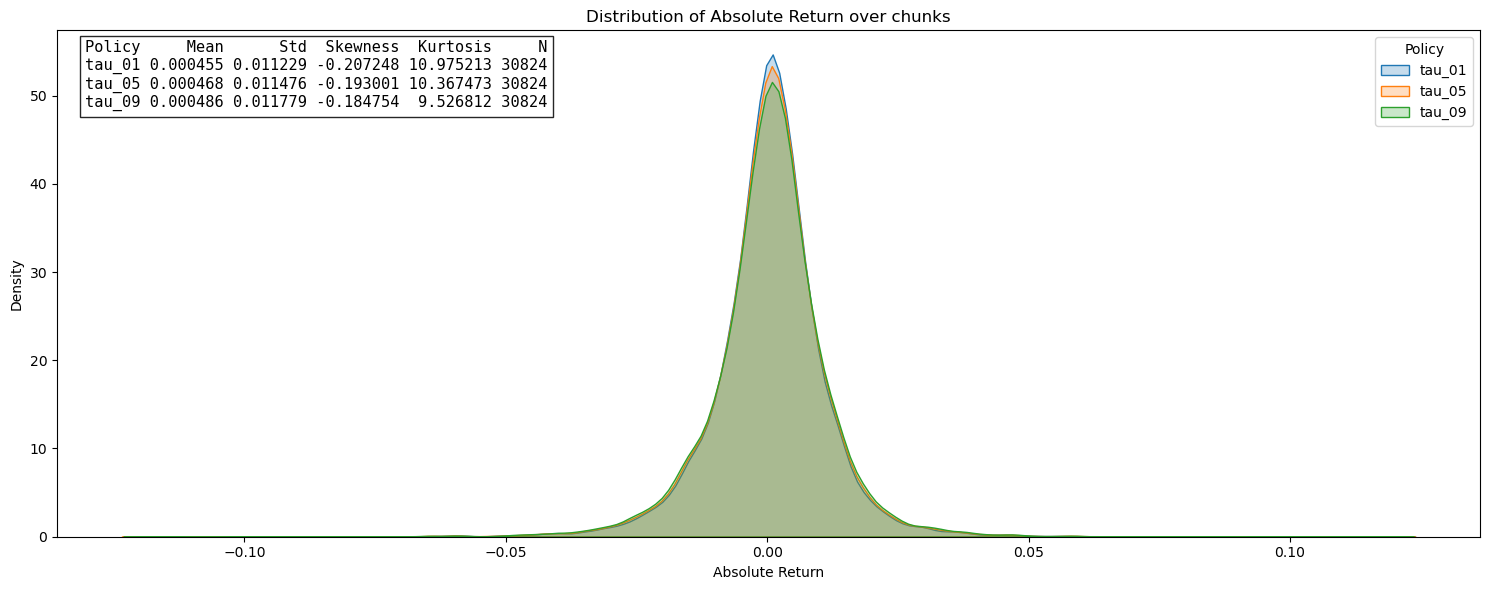

(   Policy      Mean       Std  Skewness   Kurtosis      N
 0  tau_01  0.000455  0.011229 -0.207248  10.975213  30824
 1  tau_05  0.000468  0.011476 -0.193001  10.367473  30824
 2  tau_09  0.000486  0.011779 -0.184754   9.526812  30824,
 {'01': {1234: {'00': array([-3.48768826e-04, -7.66414303e-05,  1.45771563e-03, -3.20480153e-03,
            7.22292820e-03,  1.33951851e-03, -5.92672607e-03, -3.72922993e-03,
            8.13724151e-04,  6.27241212e-05,  4.00336292e-03,  6.13596269e-03,
           -1.78077324e-03, -2.24404481e-03,  8.02517073e-04,  4.29839271e-03,
           -2.73046808e-03, -9.93228760e-05,  7.91717450e-03, -3.12802963e-03,
            7.86855082e-04,  6.25783310e-03,  1.21438468e-03,  6.02046636e-03,
            1.30371760e-03,  6.09417462e-03,  6.59956124e-03,  8.32382466e-04,
           -2.52350042e-03, -1.38472840e-02,  1.15825605e-03,  6.93972994e-03,
            8.82783194e-03, -2.85811153e-03,  1.86795385e-03, -7.42412282e-03,
            9.53572184e-05,  1.705

In [6]:


def plot_abs_return_kde_with_stats(
    dfs_chunked,                 # dict[tau_str][seed][chunk] = df
    tau_list=None,               # e.g. ["01","05","09"]; if None -> sorted keys of dfs_chunked
    scale=1221.0,                   # e.g. 1221.0 : dont forget the reward scaling!
    value_col="absolute_return", # TODO: check this how we calculated exactly!
    title="Distribution of Absolute Return over train",
    out_png="absolute_return_distribution_stats.png",):
    if tau_list is None:
        tau_list = sorted(dfs_chunked.keys())

    plt.figure(figsize=(15, 6))
    stats_list = []

    loaded_values = {}

    for tau_str in tau_list:
        absolute_returns = []

        for seed, chunk_dict in dfs_chunked.get(tau_str, {}).items():
            for chunk, df in chunk_dict.items():
                if df is None or value_col not in df.columns:
                    continue
                x = pd.to_numeric(df[value_col], errors="coerce").to_numpy() / float(scale)
                x = x[np.isfinite(x)]
                if x.size:
                    absolute_returns.append(x)

                    loaded_values.setdefault(tau_str, {}).setdefault(seed, {})[chunk] = x

        if not absolute_returns:
            print(f"[WARN] No data for tau_{tau_str}")
            continue

        combined = np.concatenate(absolute_returns)

        sns.kdeplot(combined, label=f"tau_{tau_str}", fill=True)

        stats_list.append([
            f"tau_{tau_str}",
            float(np.mean(combined)),
            float(np.std(combined, ddof=0)),
            float(skew(combined)),
            float(kurtosis(combined)),  # excess kurtosis
            int(combined.size),
        ])

    plt.xlabel("Absolute Return")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend(title="Policy")

    stats_df = pd.DataFrame(stats_list, columns=["Policy", "Mean", "Std", "Skewness", "Kurtosis", "N"])
    stats_text = stats_df.to_string(index=False, float_format=lambda x: f"{x:.6f}")

    ax = plt.gca()
    ax.text(
        0.02, 0.98, stats_text,
        fontsize=11, family="monospace",
        transform=ax.transAxes,
        va="top",
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="black")
    )

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()

    return stats_df, loaded_values







stats_df = plot_abs_return_kde_with_stats(
    dfs_chunked=dfs,
    tau_list=sorted(dfs.keys()),
    scale=1221.0,  # or 1.0 if you don't want rescaling
    out_png="absolute_return_distribution_stats.png",
    title="Distribution of Absolute Return over chunks"
)

display(stats_df)


In [7]:

SCALE = 1221.0

portfolios_by_tau, panels_by_tau, concat_df_by_tau_seed, used_files_by_tau_seed_chunk = build_tau_ensemble_returns_from_chunks(
    dfs_chunked=dfs,              # input!
    tau_levels_str=sorted(dfs.keys()),
    value_col="absolute_return",
    date_col="date",
    scale=SCALE,
    align="inner",
)

table = make_table_for_portfolios(
    portfolios_by_tau,
    periods_per_year=252,
    rf_annual=0.0,
    target=0.0,
    alpha=0.95
)

print(table)

latex = df_to_booktabs_latex(
    table,
    caption="Performance by quantile policy (OOS concatenated chunks: averaged across selected seeds)",
    label="tab:qac_perf_oos_concat_filtered"
)
print(latex)


tau_01: start=1995-04-05 00:00:00, end=2025-11-26 00:00:00, N=7706, seeds=4, chunks=16
tau_05: start=1995-04-05 00:00:00, end=2025-11-26 00:00:00, N=7706, seeds=4, chunks=16
tau_09: start=1995-04-05 00:00:00, end=2025-11-26 00:00:00, N=7706, seeds=4, chunks=16
                             tau_01     tau_05     tau_09
Ann. Mean (%)             11.476959  11.787782  12.240516
Ann. StdDev (%)           17.627268  18.022347  18.506287
Ann. SemiDev (%)          18.512157  18.929530  19.419614
CVaR 95% (%)              -2.630262  -2.685225  -2.751085
Avg DD (%)                 6.825767   7.420350   8.353352
VaR 95% (%)               -1.665534  -1.704307  -1.763695
Sharpe (ann.)              0.651091   0.654065   0.661425
Sortino (ann.)             0.619969   0.622719   0.630317
Tail-Adj Sharpe (CVaR95)   4.363428   4.389867   4.449341
Tail-Adj Sharpe (mVaR95)   7.193751   7.173548   7.178259
\begin{table}[!htbp]
\centering
\caption{Performance by quantile policy (OOS concatenated chunks: ave

In [8]:
portfolios_by_tau_chunk, panels_by_tau_chunk, summary_by_tau_chunk = build_tau_ensemble_returns_by_chunk(
    dfs_chunked=dfs,                 # input!
    tau_levels_str=sorted(dfs.keys()),
    value_col="absolute_return",
    date_col="date",
    scale=SCALE,
    align="inner",
)

all_chunks = sorted(
    {ch for tau_str in portfolios_by_tau_chunk for ch in portfolios_by_tau_chunk[tau_str].keys()},
    key=lambda x: int(x)
)

tables_by_chunk = {}
latex_by_chunk = {}

for ch in all_chunks:
    # make the exact dict make_table_for_portfolios expects: name -> pd.Series
    portfolios_for_chunk = {
        f"tau_{tau_str}": portfolios_by_tau_chunk[tau_str][ch]
        for tau_str in sorted(portfolios_by_tau_chunk.keys())
        if ch in portfolios_by_tau_chunk[tau_str]
    }

    if not portfolios_for_chunk:
        print(f"[WARN] No portfolios for chunk {ch}, skipping.")
        continue

    table = make_table_for_portfolios(
        portfolios_for_chunk,
        periods_per_year=252,
        rf_annual=0.0,
        target=0.0,
        alpha=0.95
    )

    print(f"\n=== Chunk {ch} ===")
    print(table)

    latex = df_to_booktabs_latex(
        table,
        caption=f"Performance by quantile policy (OOS chunk {ch}: averaged across selected seeds)",
        label=f"tab:qac_perf_oos_chunk_{ch}"
    )
    print(latex)

    tables_by_chunk[ch] = table
    latex_by_chunk[ch] = latex


tau_01, chunk_00: start=1995-04-05 00:00:00, end=1997-04-03 00:00:00, N=504, seeds=4
tau_01, chunk_01: start=1997-04-07 00:00:00, end=1999-04-01 00:00:00, N=501, seeds=4
tau_01, chunk_02: start=1999-04-05 00:00:00, end=2001-04-04 00:00:00, N=506, seeds=4
tau_01, chunk_03: start=2001-04-05 00:00:00, end=2003-04-03 00:00:00, N=499, seeds=4
tau_01, chunk_04: start=2003-04-07 00:00:00, end=2005-04-04 00:00:00, N=502, seeds=4
tau_01, chunk_05: start=2005-04-05 00:00:00, end=2007-04-04 00:00:00, N=504, seeds=4
tau_01, chunk_06: start=2007-04-05 00:00:00, end=2009-04-02 00:00:00, N=503, seeds=4
tau_01, chunk_07: start=2009-04-06 00:00:00, end=2011-04-04 00:00:00, N=504, seeds=4
tau_01, chunk_08: start=2011-04-05 00:00:00, end=2013-04-04 00:00:00, N=502, seeds=4
tau_01, chunk_09: start=2013-04-05 00:00:00, end=2015-04-01 00:00:00, N=502, seeds=4
tau_01, chunk_10: start=2015-04-06 00:00:00, end=2017-04-04 00:00:00, N=505, seeds=4
tau_01, chunk_11: start=2017-04-05 00:00:00, end=2019-04-04 00:00

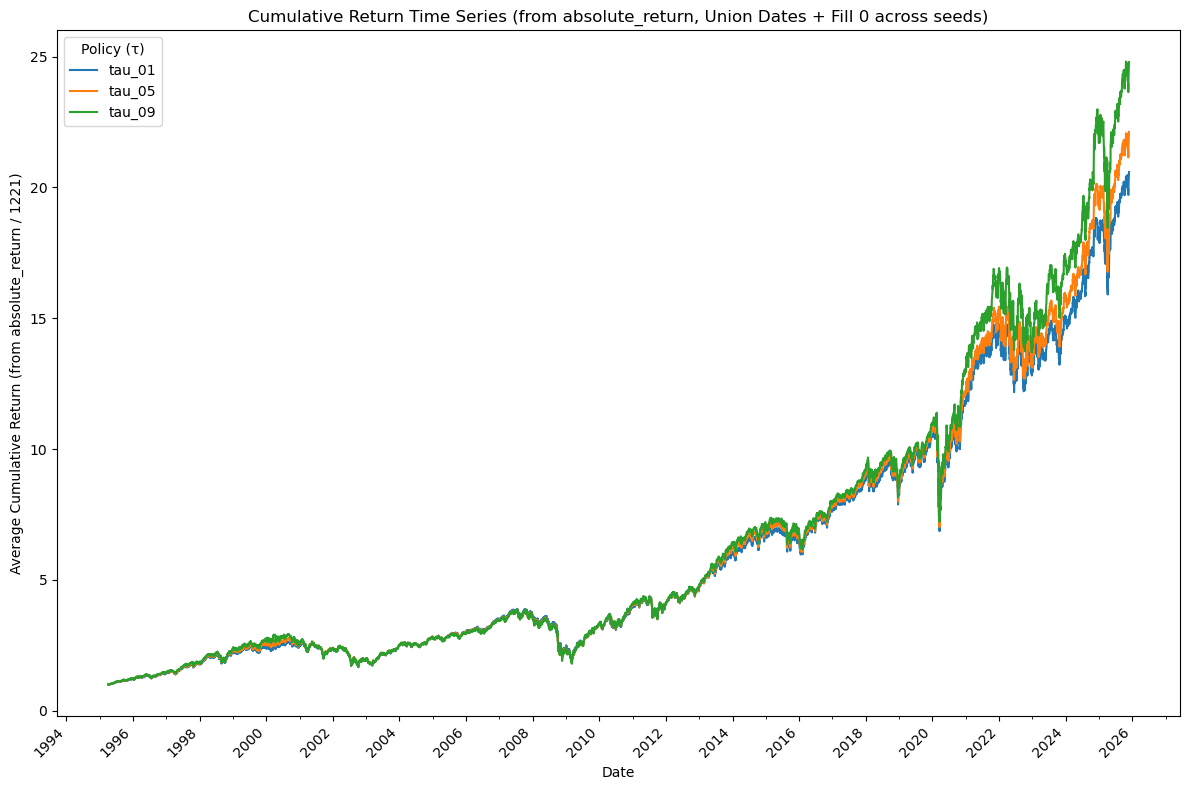

In [9]:
SCALE = 1221.0
dfs_use = dfs

def _concat_chunks_for_seed_returns(chunk_dict, date_col="date", ret_col="absolute_return"):
    """
    Concats chunks in chunk order, keeps only date + ret_col,
    sorts by date, drops duplicate dates (keeps last) to avoid overlaps.
    """
    chunks_sorted = sorted(chunk_dict.keys(), key=lambda x: int(x))
    df_list = []

    for ch in chunks_sorted:
        df = chunk_dict[ch]
        if df is None or df.empty:
            continue

        d = df.copy()
        if date_col not in d.columns or ret_col not in d.columns:
            continue

        d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
        d = d.loc[~d[date_col].isna()].copy()
        d = d.sort_values(date_col)

        d[ret_col] = pd.to_numeric(d[ret_col], errors="coerce")
        d = d.loc[np.isfinite(d[ret_col].to_numpy())].copy()

        d = d[[date_col, ret_col]].copy()
        df_list.append(d)

    if not df_list:
        return pd.DataFrame()

    out = pd.concat(df_list, ignore_index=True)
    out = out.sort_values(date_col)
    out = out.drop_duplicates(subset=[date_col], keep="last")
    out = out.reset_index(drop=True)

    return out


plt.figure(figsize=(12, 8))
ax = plt.gca()

for tau_str in sorted(dfs_use.keys()):
    seed_ret_list = []
    date_index = None

    for seed, chunk_dict in dfs_use[tau_str].items():
        df_all = _concat_chunks_for_seed_returns(
            chunk_dict,
            date_col="date",
            ret_col="absolute_return"
        )
        if df_all is None or df_all.empty:
            continue

        # UNDO scaling here
        r = pd.to_numeric(df_all["absolute_return"], errors="coerce") / float(SCALE)
        dates = pd.to_datetime(df_all["date"])

        s_ret = pd.Series(r.to_numpy(), index=dates).sort_index()
        s_ret = s_ret[~s_ret.index.duplicated(keep="last")]
        s_ret = s_ret[np.isfinite(s_ret.values)]
        if s_ret.empty:
            continue

        if date_index is None:
            date_index = s_ret.index
            seed_ret_list = [s_ret]
        else:
            # UNION dates, s_ret currect, date_index: global
            date_index = date_index.union(s_ret.index).sort_values()

            # fill missing RETURNS with 0.0 -> factor 1.0 in cumprod
            seed_ret_list = [s.reindex(date_index).fillna(0.0) for s in seed_ret_list] # Reindex all the previously stored seeds to the new (expanded)
            seed_ret_list.append(s_ret.reindex(date_index).fillna(0.0))

    if date_index is None or not seed_ret_list:
        continue

    # compute cumulative per seed from returns
    seed_cum_list = [(1.0 + s).cumprod() for s in seed_ret_list]

    # average cumulative across seeds
    M = np.vstack([s.to_numpy() for s in seed_cum_list])
    avg_cum = np.mean(M, axis=0)

    plt.plot(date_index, avg_cum, label=f"tau_{tau_str}")

# ticks every 2 years + rotate
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.YearLocator())  # optional

plt.xlabel("Date")
plt.ylabel("Average Cumulative Return (from absolute_return / 1221)")
plt.title("Cumulative Return Time Series (from absolute_return, Union Dates + Fill 0 across seeds)")
plt.legend(title="Policy (τ)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("avg_cum_from_absolute_return_scaled1221_union_fill0_2y_ticks.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
len(seed_ret_list) # for seeds

4

In [11]:
M.shape

(4, 7706)

In [12]:
M# so for each day we average across seeds

array([[ 0.99856335,  0.99932966,  1.00214665, ..., 21.278555  ,
        21.42837155, 21.52447914],
       [ 0.998984  ,  0.99892374,  1.00272841, ..., 25.90668872,
        26.10600132, 26.26913163],
       [ 0.99831528,  0.99902949,  1.00116539, ..., 26.51759983,
        26.6941462 , 26.87141523],
       [ 0.99971617,  1.00071325,  1.00426886, ..., 24.1294036 ,
        24.32332256, 24.50076206]])